# [1D-BASELINE] Exp20: Tilt Robot Baseline

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [6]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/571.54490033)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    # grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    # grace.slow_centering_eyes()
    state = grace.move_left_eye((None, 0))
    return state
    
def generate_graphs(data, y_org=219.22972847):
    # tilt_idx = tilt_arr.index(tilt)
    tilt_idx = 0
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr)
    plt.ylim([-32, 32])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    # Pixel vs Input Array (Raw)
    raw_y_pixel_arr = [x[1] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_y_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel Y Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x[1]-y_org for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel Y Value (wrt 219.2297 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x[1]-y_org) for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr)
    plt.plot(phi, color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Angles (deg)')
    plt.ylim([-32, 32])
    plt.legend(['Input Command', 'Eye Output'])
    plt.title('Theta vs Phi')

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    

In [7]:
# Input

max_tilt = 30

In [8]:
# Entry Calculation

mult = 0.1
log_cmd = []
log_cmd_str = []

mult = 0.1
for i in range(1):
    mult = mult*10
    for j in range(1,31):
        tmp = mult*j
        if tmp <= max_tilt:
            log_cmd.append(tmp)
            log_cmd_str.append("%.1f"%tmp)
        else:
            break

print(log_cmd_str)

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '30.0']


In [9]:
log_cmd = [1, 2, 4, 8, 16, 30]
log_cmd_str = ['1', '2', '4', '8', '16', '30']

In [10]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] Exp20: Tilt Robot Baseline",
    "description": None,
    "data_label": log_cmd_str,
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

In [11]:
# Center the left eye

state = slow_reset()
pixel_state = get_center_chessboard_point(left_cam.frame)
print(state)
print(pixel_state)

(0.0, 0.0)
[315.50640869140625, 202.28048706054688]


## Looping of Amplitude

In [12]:
trials = 5
time_interval = 0.015  # sec
init_amp = 0
step_size = 0.0879
num_cycles = 5
include_init = 1

In [13]:
# Looping
tilt_arr = [0]

start = time.time()
for inpt in log_cmd:

    data = {
        "tilt_arr": [],  # Designated tilt of the pan sweep 
        "input_arr": [],  # Data points or Triangle Wave
        "init_arr": [],  # Initial data points as point of reference
        "pixel_arr": [],  # row: tilt value, column: pan value
        "initial_motor_state": [],  # Motor state before experiment
        "initial_pixel_state": [],  # Pixel state before experiment
        "end_motor_state": [],  # Motor state after experiment
        "end_pixel_state": []  # Pixel state after experiment
    }
    
    # Generation of triangle wave
    max_amp = inpt
    min_amp = -inpt
    input_arr = generate_triangle_wave(init_amp, min_amp, max_amp, step_size, num_cycles, include_init)
    
    # Experiment Sweep

    data["tilt_arr"] = tilt_arr
    data["input_arr"] = input_arr.tolist()



    # Initial State
    slow_reset()
    time.sleep(0.75)
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

    cnt = 0
    for tilt in tilt_arr:
        pixel_arr = []
        for ang in input_arr:
            cnt+=1
            clear_output(wait=True)
            grace.direct_move_left_eye((None, ang))
            time.sleep(time_interval)

            in_cnt = 0
            while(in_cnt < 5):
                try:
                    pixel_pt = get_center_chessboard_point(left_cam.frame)
                except:
                    pass
                else:
                    break
                in_cnt+=1
            pixel_arr.append(pixel_pt)
            print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
            print(f"pan:{tilt}, tilt:{ang}")
        data["pixel_arr"].append(pixel_arr)

    # End State
    slow_reset()
    time.sleep(0.75)
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    
    # Appending to Data List

    data_list.append(data)


print("Elapsed Time:", time.time()-start)

6821/6821
pan:0, tilt:0.0
Elapsed Time: 481.0265634059906


# Saving the Data

In [14]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP20_TiltRobotBaseline")

Data saved in: C:\dev\robot_control\const_results\20230530_014928_625460_left_1D-BASELINE_EXP20_TiltRobotBaseline.pickle


# Loading the Data

In [15]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

In [33]:
def random_colors(n):
    return np.random.rand(n,3)

rand_colors = random_colors(len(data_load["data"]))

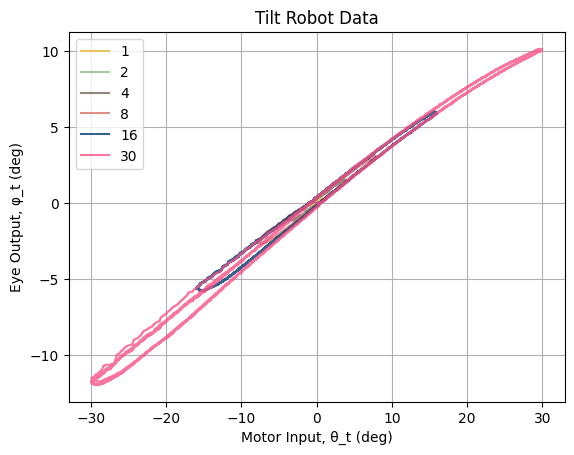

In [34]:
# Data Superposition

# Time Series Eye Output vs Input Array
y_org = 202
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.8)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)

(-2.0, 7.0)

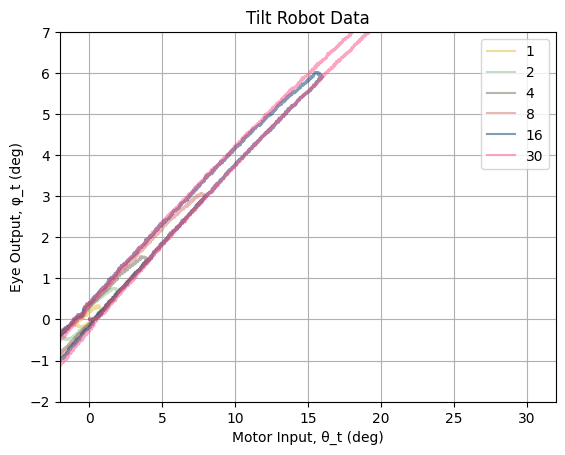

In [35]:
# Zoomed Data Superposition

# Time Series Eye Output vs Input Array
y_org = 202
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)
plt.xlim([-2, 32])
plt.ylim([-2, 7])

(-2.0, 2.0)

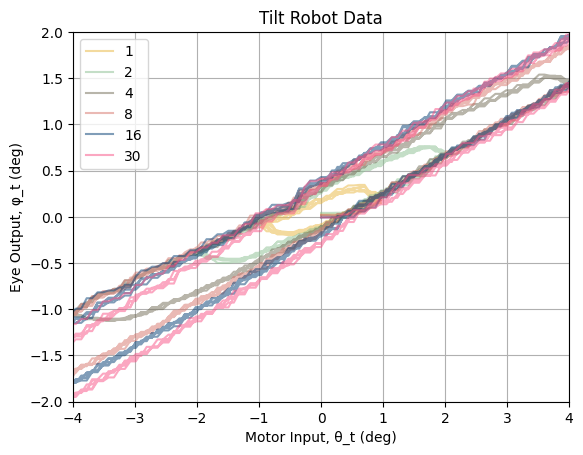

In [36]:
# Zoomed Data Superposition

# Time Series Eye Output vs Input Array
y_org = 202
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)
plt.xlim([-4, 4])
plt.ylim([-2, 2])

(-16.0, 2.0)

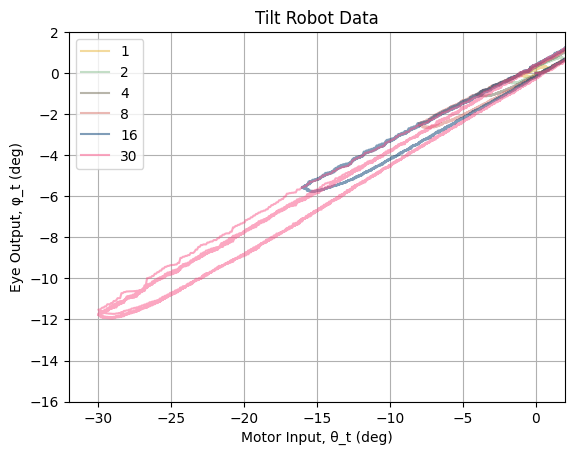

In [37]:
# Zoomed Data Superposition

# Time Series Eye Output vs Input Array
y_org = 202
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)
plt.xlim([-32, 2])
plt.ylim([-16, 2])